In [1]:
import sys
import torch


seed = 42
#torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy
import matplotlib.pyplot as plt 
import seaborn as sns

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree
import fiora.visualization.spectrum_visualizer as sv
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder
from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework

from fiora.MOL.collision_energy import NCE_to_eV
from fiora.MS.spectral_scores import spectral_cosine, spectral_reflection_cosine, reweighted_dot
from fiora.MS.ms_utility import merge_annotated_spectrum
from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from sklearn.model_selection import train_test_split
print(f'Working with Python {sys.version}')


[09:22:47] WARNING: not removing hydrogen atom without neighbors
[09:22:47] WARNING: not removing hydrogen atom without neighbors
[09:22:47] WARNING: not removing hydrogen atom without neighbors


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


### Model

In [106]:
depth = 6
v: str = "0.1.0"
MODEL_PATH = f"../models/fiora_OS_v{v}.pt" # Release version
#MODEL_PATH="../../checkpoint_training.best.pt"
#MODEL_PATH="../../checkpoint_fine_tuned_Mona_v1.best.pt"
#MODEL_PATH="../../../checkpoint_all_wells_new.best.pt"
#MODEL_PATH="../Checkpoints/checkpoint_test_new_mona_tuned.best.pt"
MODEL_PATH="../../../checkpoint_all_wells_mona_ft.best.pt"
try:
    model = GNNCompiler.load_from_state_dict(MODEL_PATH)
except:
    raise NameError("Error: Failed loading from state dict.")
model.model_params    

{'param_tag': 'default',
 'gnn_type': 'RGCNConv',
 'depth': 6,
 'hidden_dimension': 300,
 'dense_layers': 2,
 'embedding_aggregation': 'concat',
 'embedding_dimension': 300,
 'input_dropout': 0.2,
 'latent_dropout': 0.1,
 'node_feature_layout': {'symbol': 10, 'num_hydrogen': 5, 'ring_type': 5},
 'edge_feature_layout': {'bond_type': 4, 'ring_type': 5},
 'static_feature_dimension': 9,
 'static_rt_feature_dimension': 8,
 'output_dimension': 10,
 'atom_features': ['bond_type', 'ring_type'],
 'setup_features': ['collision_energy',
  'molecular_weight',
  'precursor_mode',
  'instrument'],
 'setup_features_categorical_set': {'instrument': ['HCD',
   'Q-TOF',
   'IT-FT/ion trap with FTMS',
   'IT/ion trap'],
  'precursor_mode': ['[M+H]+', '[M-H]-']},
 'rt_features': ['molecular_weight', 'precursor_mode', 'instrument'],
 'rt_supported': False,
 'ccs_supported': False,
 'version': 'x.x.x',
 'training_label': 'compiled_probsALL'}

In [107]:
has_m_plus = False
if "setup_features_categorical_set" in model.model_params.keys():
    print(model.model_params["setup_features_categorical_set"]["precursor_mode"])
    if "[M]+" in model.model_params["setup_features_categorical_set"]["precursor_mode"]:
        has_m_plus = True

['[M+H]+', '[M-H]-']


## Data

In [108]:
# key map to read metadata from pandas DataFrame
metadata_key_map = {
                "name": "Name",
                 "collision_energy":  "CE", 
                "instrument": "Instrument_type",
                "ionization": "Ionization",
               "precursor_mz": "PrecursorMZ",
                "precursor_mode": "Precursor_type",      
                 "retention_time": "RT",
                 "ccs": "CCS"
                 }


def load_training_data(input_file):
    L = LibraryLoader()
    df = L.load_from_csv(input_file)
    return df
    
def restore_dict(df):
    dict_columns = ["peaks"]#, "summary"]
    for col in dict_columns:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    df['group_id'] = df['group_id'].astype(int)
    
    return df

def train_val_test_split(keys, test_size=0.1, val_size=0.1, rseed=seed): ######################################### Dont forget to change ( 0.1 0.1)
    temp_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=rseed)
    adjusted_val_size = val_size / (1 - test_size)
    train_keys, val_keys = train_test_split(temp_keys, test_size=adjusted_val_size, random_state=rseed)
    
    return train_keys, val_keys, test_keys
def add_grouping(df):
    print("Split into training, testing and validation")
    group_ids = df["group_id"].astype(int)
    keys = np.unique(group_ids)
    example_not_in_test_split = True
    
    for i in range(100):
        train, val, test = train_val_test_split(keys, rseed=seed + i)
    df["dataset"] = df["group_id"].apply(lambda x: 'train' if x in train else 'validation' if x in val else 'test' if x in test else 'VALUE ERROR')
    return df

In [109]:
#df, df_org = load_training_data()
#df = load_training_data("../datasplits_Feb25_25.csv")

df = load_training_data("../../../Tims_Tof_data/MetaboScape/processed_data/test_A01_B23_processed_new.csv")
df = load_training_data("../../../Tims_Tof_data/MetaboScape/plate20250408_5ppm_preprocessed.csv")
df=restore_dict(df)

df=add_grouping(df)
print(df.groupby("lib")["group_id"].unique().apply(len))


Split into training, testing and validation
lib
TimsTof    19464
Name: group_id, dtype: int64


In [110]:
df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight"])
df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)

#df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder=None), axis=1)


In [111]:
print(df.groupby("dataset")["group_id"].unique().apply(len))

print("Reducing data to test set.")
df_train = df[df["dataset"] != "test"]
df_test = df[df["dataset"] == "test"]


dataset
test           1947
train         15570
validation     1947
Name: group_id, dtype: int64
Reducing data to test set.


In [112]:
%%capture
CE_upper_limit = 100.0
weight_upper_limit = 1900.0

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
model_setup_feature_sets = None
if "setup_features_categorical_set" in model.model_params.keys():
    model_setup_feature_sets = model.model_params["setup_features_categorical_set"]    
    # TODO Refactor this:
    for i, data in df_test.iterrows():
        df_test.loc[i]["summary"]["instrument"] = "HCD"
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"], sets_overwrite=model_setup_feature_sets)
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"], sets_overwrite=model_setup_feature_sets)


def process_dataframes(df_train, df_test):

    df_train["Metabolite"] = df_train["SMILES"].apply(Metabolite) # TRAIN Metabolites are only tracked for tanimoto distance
    df_test["Metabolite"] = df_test["SMILES"].apply(Metabolite)
    df_test["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())


    setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
    setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
    rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

    df_test["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
    df_test.apply(lambda x: x["Metabolite"].set_id(x["group_id"]) , axis=1)

    df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
    df_test.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

    df_test["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
    df_test.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)

    return df_train, df_test

In [113]:
df_train, df_test = process_dataframes(df_train, df_test)


/tmp/ipykernel_16840/2126093782.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Metabolite"] = df_train["SMILES"].apply(Metabolite) # TRAIN Metabolites are only tracked for tanimoto distance
/tmp/ipykernel_16840/2126093782.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Metabolite"] = df_test["SMILES"].apply(Metabolite)


##### Load Casmi data

In [23]:
casmi16_path = f"../../../CASMI16/casmi16_withCCS.csv"
#casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_withCCS.csv"

df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
#df_cast = pd.read_csv(f"{home}/data/metabolites/CASMI_2016/casmi16t_withCCS.csv", index_col=[0], low_memory=False) # f"{home}/data/metabolites/CASMI_2016/casmi16_training_combined.csv"
#df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)

# Restore dictionary values
dict_columns = ["peaks", "Candidates"]
for col in dict_columns:
    df_cas[col] = df_cas[col].apply(ast.literal_eval)
    #df_cast[col] = df_cast[col].apply(ast.literal_eval)

df_cas["is_priority"] = True
#df_cast["is_priority"] = False
#df_cas22["peaks"] = df_cas22["peaks"].apply(ast.literal_eval)
#df_cas22["ChallengeNum"] = df_cas22["ChallengeName"].apply(lambda x: int(x.split("-")[-1]))
#df_cas22["is_priority"] = (df_cas22["ChallengeNum"] < 250).astype(bool)




def closest_cfm_ce(CE):
    ref = np.array([10, 20, 40])
    abs_error = abs(ref - CE)
    i = np.argmin(abs_error)
    return str(ref[i])

In [25]:
%%capture


df_cas["dataset"] = "CASMI 16"
df_cas["RETENTIONTIME"] = df_cas["RTINSECONDS"] / 60.0
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df_cas["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas["CE"] = 20.0 # actually stepped 20/35/50
df_cas["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cas["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=300 * PPM), axis=1)



In [ ]:
df_cas22["dataset"] = "CASMI 22"
df_cas22["Metabolite"] = df_cas22["SMILES"].apply(Metabolite)
df_cas22["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas22["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas22["CE"] = df_cas22.apply(lambda x: NCE_to_eV(x["NCE"], x["precursor_mz"]), axis=1)
df_cas22 = df_cas22[df_cas22["CE"] < CE_upper_limit] 
df_cas22 = df_cas22[df_cas22["CE"] > 0] 
#df_cas22 = df_cas22[df_cas22.is_priority]

metadata_key_map22 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "precursor_mz",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "ChallengeRT"
                 }

df_cas22["summary"] = df_cas22.apply(lambda x: {key: x[name] for key, name in metadata_key_map22.items()}, axis=1)
df_cas22.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

# Fragmentation
df_cas22["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas22.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=300 * PPM), axis=1) # Optional: use mz_cut instead

df_cas22 = df_cas22.reset_index()

df_cas22["library"] = "CASMI-22"
df_cas22["RETENTIONTIME"] = df_cas22["ChallengeRT"] # "RT_min"
df_cas22["cfm_CE"] = df_cas22["CE"].apply(closest_cfm_ce)
df_cas22[["NCE", "CE", "cfm_CE"]]

In [ ]:
%%capture
from fiora.MOL.collision_energy import NCE_to_eV

df_cast["dataset"] = "CASMI 16 Training"
df_cast["RETENTIONTIME"] = df_cast["RTINSECONDS"] / 60.0
df_cast["Metabolite"] = df_cast["SMILES"].apply(Metabolite)
df_cast["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cast["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cast["CE"] = 20.0 # actually stepped 20/35/50
df_cast["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cast["summary"] = df_cast.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cast.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cast["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cast.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=300 * PPM), axis=1)


## Model Training and Testing

In [114]:
from fiora.GNN.Trainer import Trainer
import torch_geometric as geom

if torch.cuda.is_available(): 
 dev = "cuda:0"
else: 
 dev = "cpu" 

print(f"Running on device: {dev}")




Running on device: cuda:0


##### Prepare Model

In [115]:
#model loaded in the start

model.eval()
model = model.to(dev)

fiora = SimulationFramework(None, dev=dev, with_RT=True, with_CCS=True)


model.model_params


{'param_tag': 'default',
 'gnn_type': 'RGCNConv',
 'depth': 6,
 'hidden_dimension': 300,
 'dense_layers': 2,
 'embedding_aggregation': 'concat',
 'embedding_dimension': 300,
 'input_dropout': 0.2,
 'latent_dropout': 0.1,
 'node_feature_layout': {'symbol': 10, 'num_hydrogen': 5, 'ring_type': 5},
 'edge_feature_layout': {'bond_type': 4, 'ring_type': 5},
 'static_feature_dimension': 9,
 'static_rt_feature_dimension': 8,
 'output_dimension': 10,
 'atom_features': ['bond_type', 'ring_type'],
 'setup_features': ['collision_energy',
  'molecular_weight',
  'precursor_mode',
  'instrument'],
 'setup_features_categorical_set': {'instrument': ['HCD',
   'Q-TOF',
   'IT-FT/ion trap with FTMS',
   'IT/ion trap'],
  'precursor_mode': ['[M+H]+', '[M-H]-']},
 'rt_features': ['molecular_weight', 'precursor_mode', 'instrument'],
 'rt_supported': False,
 'ccs_supported': False,
 'version': 'x.x.x',
 'training_label': 'compiled_probsALL'}

In [116]:
np.seterr(invalid='ignore')
def simulate_all(model, DF):
    return fiora.simulate_all(DF, model)

    
def test_model(model, DF):
    dft = simulate_all(model, DF)
    return dft

##### Test CASMI 16 and 22

In [53]:



def test_cas16(model, df_cas=df_cas):
    
    df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step1_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_20") #I guess this is the actuall evaluation?

    df_cas["NCE"] = 35.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step2_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_35")


    df_cas["NCE"] = 50.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step3_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_50")

    df_cas["avg_CE"] = (df_cas["step1_CE"] + df_cas["step2_CE"] + df_cas["step3_CE"]) / 3
    df_cas["CE"] = df_cas["avg_CE"]
    
    df_cas["merged_peaks"] = df_cas.apply(lambda x: merge_annotated_spectrum(merge_annotated_spectrum(x["sim_peaks_20"], x["sim_peaks_35"]), x["sim_peaks_50"]) , axis=1)
    df_cas["sim_peaks"] = df_cas["merged_peaks"] 
    df_cas["merged_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["merged_sqrt_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_sqrt_bias"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, with_bias=True)[1], axis=1)
    df_cas["merged_sqrt_cosine_wo_precursor"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, remove_mz=x["Metabolite"].get_theoretical_precursor_mz(x["Metabolite"].metadata["precursor_mode"])), axis=1)
    df_cas["merged_refl_cosine"] = df_cas.apply(lambda x: spectral_reflection_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_steins"] = df_cas.apply(lambda x: reweighted_dot(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["spectral_cosine"] = df_cas["merged_cosine"] # just remember it is merged
    df_cas["spectral_sqrt_cosine"] = df_cas["merged_sqrt_cosine"] # just remember it is merged
    df_cas["spectral_sqrt_cosine_wo_prec"] = df_cas["merged_sqrt_cosine_wo_precursor"] # just remember it is merged
    df_cas["spectral_sqrt_bias"] = df_cas["merged_sqrt_bias"] # just remember it is merged

    df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"])
    df_cas["RT_pred"] = df_cas["RT_pred_35"]
    df_cas["RT_dif"] = df_cas["RT_dif_35"]
    df_cas["CCS_pred"] = df_cas["CCS_pred_35"]
    df_cas["library"] = "CASMI-16"

    
    df_cas["cfm_CE"] = df_cas["avg_CE"].apply(closest_cfm_ce)
    
    return df_cas

# Run test

In [117]:
print(f"Testing the model")
np.seterr(invalid='ignore')
df_test = test_model(model, df_test)
#df_msnlib_test = test_model(model, df_msnlib_test)
df_cas = test_cas16(model)
#df_cast = test_cas16(model, df_cas=df_cast)
#df_cas22 = test_model(model, df_cas22)
print("Done")


Testing the model
Done


In [98]:
def get_percentile(df,p, metric):
    x=df[metric]
    
    pcen=np.percentile(x,p)
    #i_high=np.asarray([i-pcen if i-pcen>=0 else x.max()-pcen for i in x]).argmin()
   # i_low=np.asarray([i-pcen if i-pcen<=0 else x.min()-pcen for i in x]).argmax()
    i_near=abs(x-pcen).argmin()
    return i_near

0 COc1cc2CCN[C@@H](c2cc1OC)c3cc4OCOc4cc3[N+](=O)[O-]
1 O=CNc1n[nH]cc1c2ccccc2
2 COc1ccc(cc1OC)S(=O)(=O)N(CC(=O)NCc2ccncc2)c3ccc(C)cc3
3 COCC(=O)N1CCN(CC1)C(=O)[C@@H]2CC[C@@H](CN3C(=O)N(C)c4ccc(OC)cc4C3=O)CC2
4 Clc1ccc(CCCC(=O)N[C@@H]2CCCN(C2)C(=O)c3ccccc3)cc1
5 CCn1nc(C(=O)NC)c2C[C@@H](CCc12)NCc3ccccc3C
6 CC(=O)c1ccc2[nH]c3C(=O)CCCc3c2c1
7 C[C@@H]1CN(C[C@H]1CO)C(=O)Nc2ccc(OCCc3ccccc3)nc2
8 Fc1ccc(cc1)[C@@H]2CNC(=O)C23CCN(CC3)C4(CCCCC4)c5ccc(F)cc5
9 COc1nc(N)ncc1C(=O)NC2CCN(Cc3ccccc3)CC2


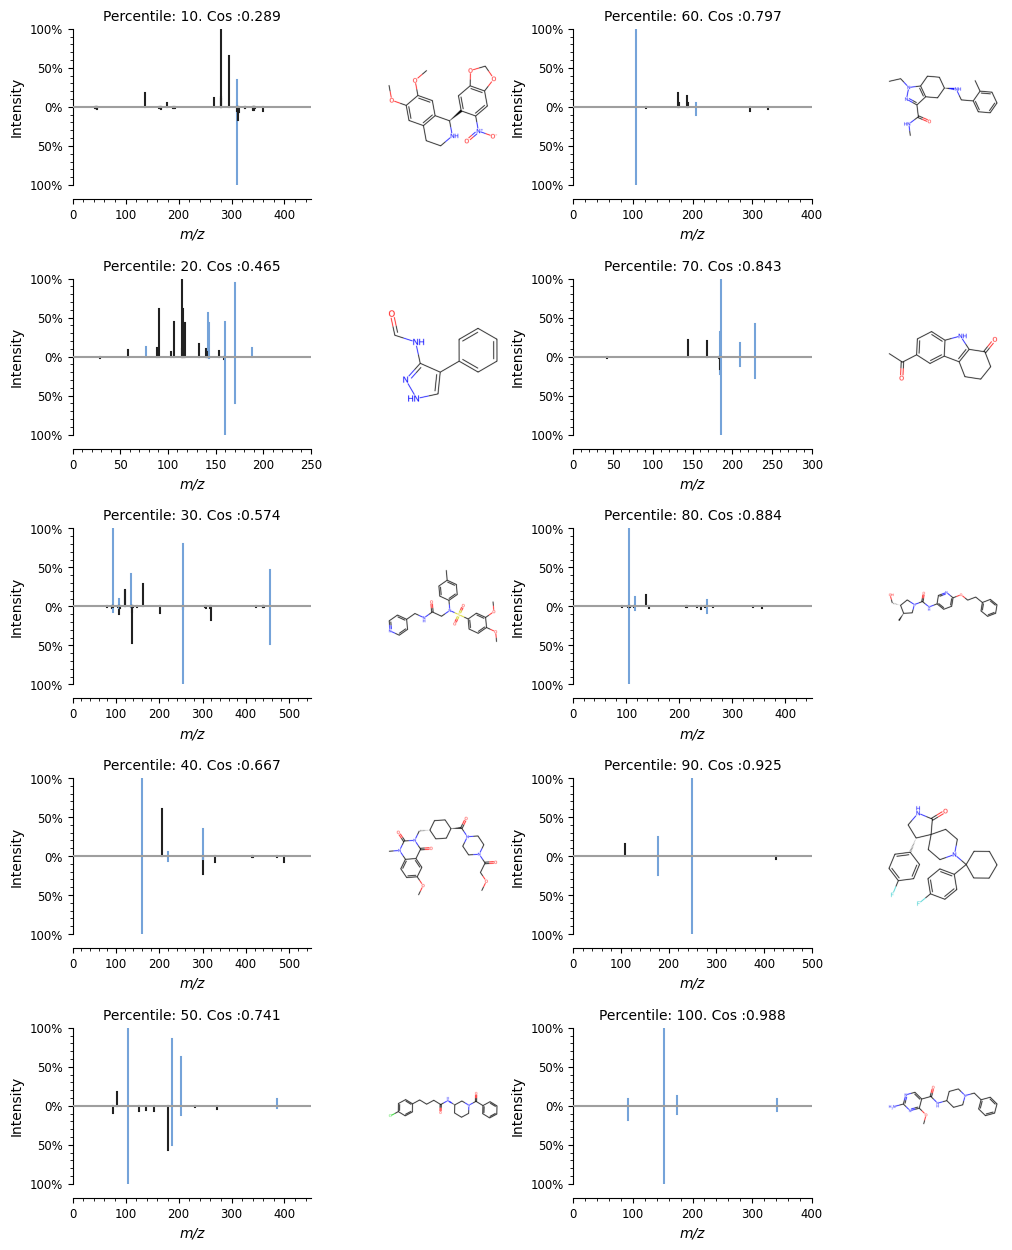

In [120]:

def plot_percentile(df,p_range, metric, start, end):
           # reset_matplotlib()
            indexes=[]
            m,n=0,0
            for i in p_range:
                indexes.append(get_percentile(df,i, metric))
            
            fig, axs = plt.subplots(5,4,figsize=(12,15), gridspec_kw={'width_ratios': [2, 1,2,1]}, sharey=False)#, sharex=True, sharey=True)
    
            for j,index in enumerate(indexes):
                
                data=df.iloc[index,:]
                print(j,data["SMILES"])
                ax = sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, ax=axs[m,n], highlight_matches=True)
                img = data["Metabolite"].draw(ax= axs[m,n+1])
                axs[m,n].set_title("Percentile: "+ str(p_range[j])+". Cos :"+str(round(data[metric],3)), fontsize=10)
                if j<4:
                    n=0
                    m=m+1
                if j==4:
                    m=0
                    n=2
                if j>4:
                    n=2
                    m=m+1
            plt.subplots_adjust( wspace=0.4,hspace=0.6)
            plt.show()
plot_percentile(df_test, [10,20,30,40,50,60,70,80,90,100], "spectral_sqrt_cosine" , 1, 10)        
#plot_percentile(df_cas, [10,20,30,40,50,60,70,80,90,100], "spectral_sqrt_cosine" , 1, 10) 
#plot_percentile(df_test, [20,40,60,80,100], "spectral_sqrt_cosine" , 1, 10)  

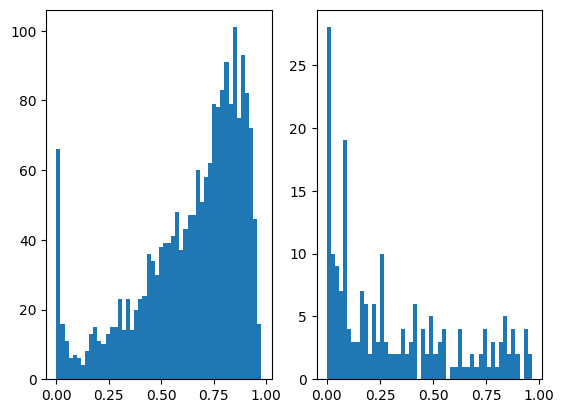

In [65]:
#reset_matplotlib()
fig, axs=plt.subplots(1,2)
axs[0].hist(df_test["spectral_sqrt_cosine"], bins=50)
axs[1].hist(df_cas["spectral_sqrt_cosine_wo_prec"], bins=50)

plt.show()

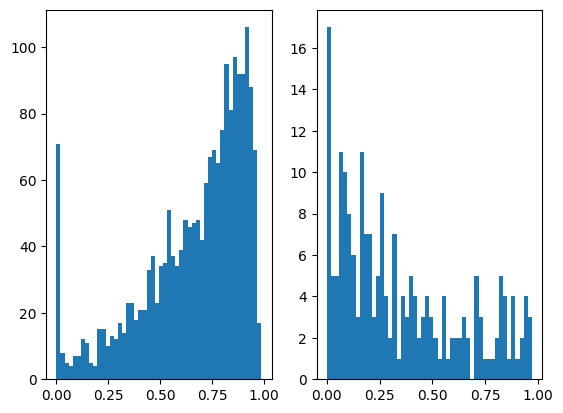

In [118]:
## For original 
#reset_matplotlib()
fig, axs=plt.subplots(1,2)
axs[0].hist(df_test["spectral_sqrt_cosine"], bins=50)
axs[1].hist(df_cas["spectral_sqrt_cosine_wo_prec"], bins=50)

plt.show()

In [119]:
# Default score
score = "spectral_sqrt_cosine"
#^score = "spectral_sqrt_cosine_wo_prec"
avg_func = np.median


fiora_res = {"model": "Fiora", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score]), "Test-": avg_func(df_test[df_test["Precursor_type"] == "[M-H]-"][score])}#, "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score]), "CASMI16-":avg_func(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score])}#, "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score]), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score])} 
             

summaryPos = pd.DataFrame( [fiora_res])#, cfm_id, ice_res])
print("Summary test sets")
summaryPos

Summary test sets


/home/michaelah/miniconda3/envs/fiora/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,model,Test+,Test-
0,Fiora,0.740859,NaN


#### Statistics

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns
from fiora.visualization.define_colors import *

### UMAP

In [45]:
df_test["group_id"] = df_test["group_id"].astype(int)
df_test.drop_duplicates("group_id", keep="first")[["group_id", "SMILES"]]
# Use classyfire via text interface to produce output csv: http://classyfire.wishartlab.com/#chemical-text-query

,group_id,SMILES
66,12,c1cc(ccc1n2cc(c(=O)c3c2cc(c(c3)F)N4CCNCC4)C(=O...
258,49,CN(C)CCCN1c2ccccc2Sc3c1cc(cc3)Cl
499,94,CC1=C(CCN2CCC(CC2)C2=NOC3=CC(F)=CC=C23)C(=O)N2...
598,113,CC(C)C[C@H](CN)CC(O)=O
625,118,CN1N(C(=O)C(NC(C)=O)=C1C)C1=CC=CC=C1
...,...,...
148340,5202,C([C@@H]1[C@H]([C@H]([C@H](N2C=NC(=C2N)C(=N)O)...
149099,5234,C(C(CC(=O)O)O)C(=O)O
149667,3823,C(CO)C(C(=O)O)O
149679,5259,C1=CC(=CC(=C1)/C(=N/CC(=O)O)/O)O


In [ ]:
# e = reducer.transform(test_embeddings)

### Tanimoto distance

In [47]:
df_cas["Dataset"] = "CASMI 16"
#df_cas22["Dataset"] = "CASMI 22"
df_test["Dataset"] = "Test split"
#df_msnlib_test["Dataset"] = "MSnLib"
C = pd.concat([df_test, df_cas], ignore_index=True)

In [48]:
calc_tanimoto = True # This may tak a long time
if calc_tanimoto:    
    print("Calculating Tanimoto scores. This may take a while")
    df_cas.loc[:,"tanimoto"] = np.nan
    for i,d in df_cas.iterrows():
        df_cas.at[i, "tanimoto"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
        df_cas.at[i, "tanimoto3"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"], finger="morgan3")).max()
        
   
    df_test.loc[:,"tanimoto"] = np.nan
    for i,d in df_test.iterrows():
        df_test.at[i, "tanimoto"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
        df_test.at[i, "tanimoto3"] = df_train[df_train["dataset"] == "training"]["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"], finger="morgan3")).max()
     

Calculating Tanimoto scores. This may take a while


In [49]:
df_test["group_id"] = df_test["group_id"].astype(int)
new_value_offset = 100000
# Function to assign unique metabolite identifiers
def assign_metabolite_ids(df_ref: pd.DataFrame, metabolite_id_map):
    for i, data in df_ref.iterrows():
        metabolite = data["Metabolite"]
        is_new = True
        for id, other in metabolite_id_map.items():
            if metabolite == other:
                # Set the metabolite ID in the dataframe
                df_ref.loc[i, "group_id"] = int(id)
                is_new = False
                break
        if is_new:
            new_id = new_value_offset + len(metabolite_id_map)
            df_ref.loc[i, "group_id"] = int(new_id)
            metabolite_id_map[int(new_id)] = metabolite

if calc_tanimoto:
    # Initialize the metabolite_id_map with metabolites from df_test
    metabolite_id_map = {}
    for group_id in df_test["group_id"].unique():
        metabolite = df_test.loc[df_test["group_id"] == group_id, "Metabolite"].iloc[0]
        metabolite_id_map[int(group_id)] = metabolite


    # Apply the function to each dataframe

    assign_metabolite_ids(df_cas, metabolite_id_map)

    
  
    df_cas["group_id"] = df_cas["group_id"].astype(int)



/tmp/ipykernel_7540/1739159818.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.pointplot(ax=ax, data=C, x=pd.cut(C[C["Precursor_type"] == "[M+H]+"]['tanimoto3'], bins=[x/10.0 for x in list(range(2,11,1))]), y="spectral_sqrt_cosine", palette=sns.color_palette("bright"), capsize=.0, hue="Dataset", dodge=0.25, estimator="median") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")


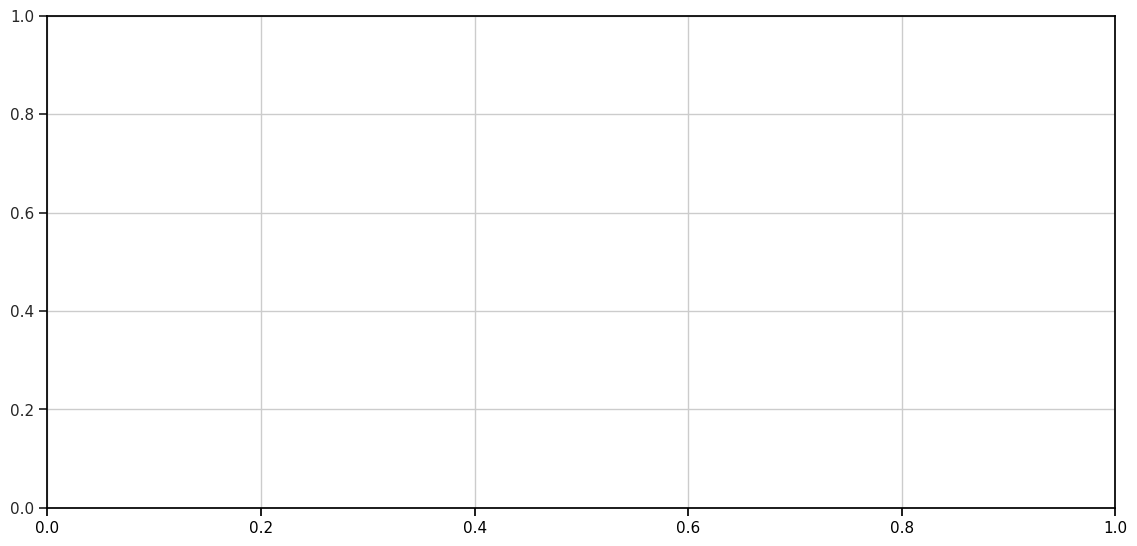

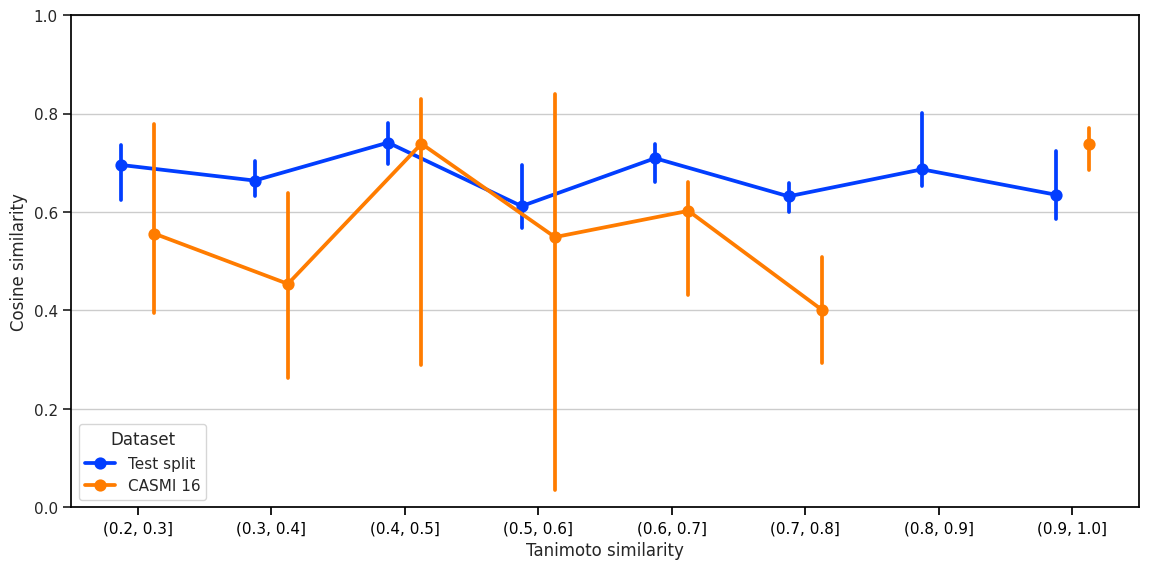

In [51]:
from fiora.visualization.define_colors import *

if calc_tanimoto:
    set_light_theme()
    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08)

    C = pd.concat([df_test, df_cas], ignore_index=True)
    sns.pointplot(ax=ax, data=C, x=pd.cut(C[C["Precursor_type"] == "[M+H]+"]['tanimoto3'], bins=[x/10.0 for x in list(range(2,11,1))]), y="spectral_sqrt_cosine", palette=sns.color_palette("bright"), capsize=.0, hue="Dataset", dodge=0.25, estimator="median") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    plt.ylim([0, 1])
    plt.legend(title="Dataset", loc="lower left")
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")
    
    # fig.savefig(f"{home}/images/paper/tanimoto_withcasmi.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_withcasmi.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_withcasmi.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
    plt.show()

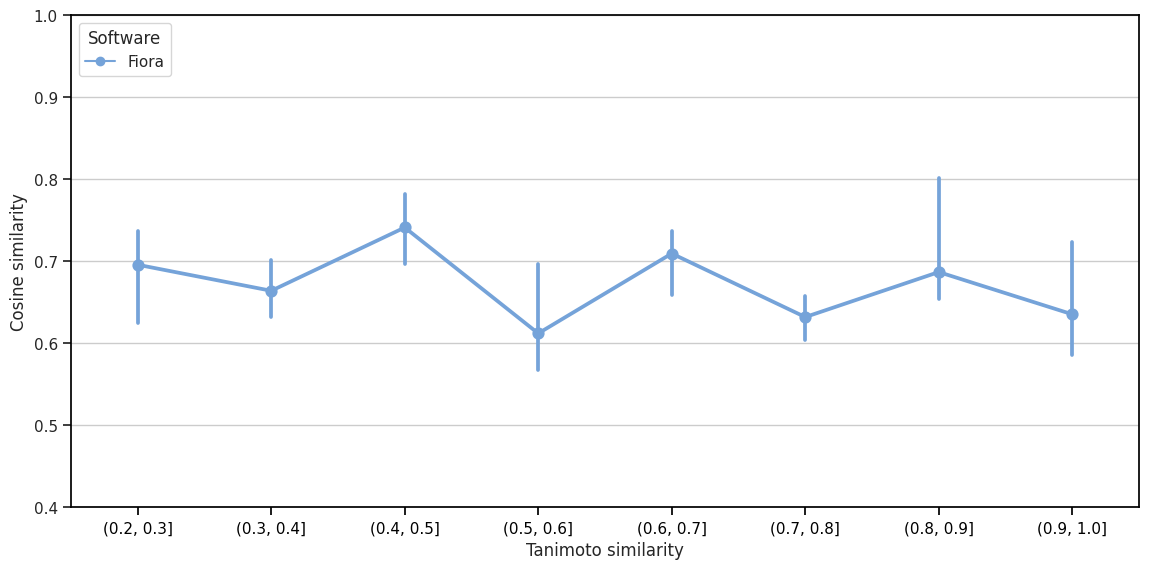

In [54]:
if calc_tanimoto:
    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08)

    
    sns.pointplot(ax=ax, data=C, x=pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2,11,1))]), y="spectral_sqrt_cosine", capsize=.0, color=lightblue_hex, estimator="median") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
  #  sns.pointplot(ax=ax, data=C, x=pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2,11,1))]), y="cfm_sqrt_cosine", capsize=.0, color="gray", estimator="median", linestyle="--") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
  #  sns.pointplot(ax=ax, data=C, x=pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2,11,1))]), y="ice_sqrt_cosine", capsize=.0, color=lightpink_hex, estimator="median") #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    plt.ylim([0.4, 1])
    custom_lines = [plt.Line2D([0], [0], color=lightblue_hex, linestyle='-', marker="o"), plt.Line2D([0], [0], color='gray', linestyle='--', marker="o"), plt.Line2D([0], [0], color=lightpink_hex, linestyle='-', marker="o")]
    plt.legend(custom_lines, ["Fiora"], title="Software", loc="upper left")
    
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")
    # fig.savefig(f"{home}/images/paper/tanimoto.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)

    plt.show()

/tmp/ipykernel_7540/1276366666.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)].groupby(binned_data)["group_id"].nunique().reset_index(name="unique_group_ids")


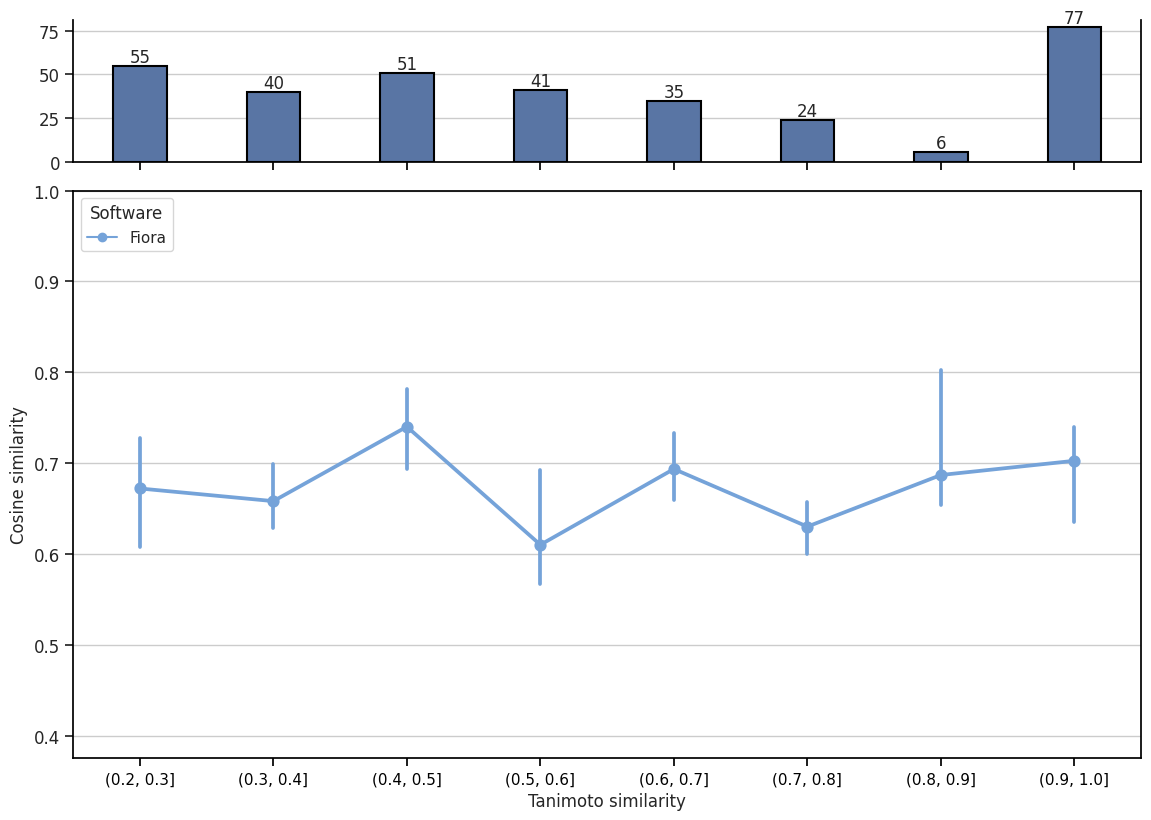

In [56]:
datasets = ["Test split", "CASMI 16"]
score_func = "spectral_sqrt_cosine"
if calc_tanimoto:
    fig, axs = plt.subplots(2,1, figsize=(12, 9), height_ratios=[1,4], sharex=True)
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08, hspace=0.08)

    binned_data = pd.cut(C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)]["tanimoto3"], bins=[x/10.0 for x in list(range(2,11,1))]).dropna()
    grouped_data = C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)].groupby(binned_data)["group_id"].nunique().reset_index(name="unique_group_ids")

    sns.barplot(ax=axs[0], x=binned_data.cat.categories, y="unique_group_ids", data=grouped_data, linewidth=1.5, edgecolor="black")

    for i in range(len(axs[0].containers)):
        axs[0].bar_label(axs[0].containers[i], fontsize=12)
    axs[0].set_ylabel("", fontsize=14)
    axs[0].set_xlabel("", fontsize=14)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(True)
    axs[0].tick_params(axis='y', labelsize=12) 
    adjust_bar_widths(axs[0], 0.5)
    err = ('ci', 95)
    sns.pointplot(ax=axs[1], data=C, x=binned_data, y=score_func, capsize=.0, color=lightblue_hex, estimator="median", errorbar=err) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
   # sns.pointplot(ax=axs[1], data=C, x=binned_data, y=score_func.replace("spectral", "cfm"), capsize=.0, color="gray", estimator="median", linestyle="--", errorbar=err) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
   # sns.pointplot(ax=axs[1], data=C, x=binned_data, y=score_func.replace("spectral", "ice"), capsize=.0, color=lightpink_hex, estimator="median", errorbar=err) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    plt.ylim([0.375, 1])
    custom_lines = [plt.Line2D([0], [0], color=lightblue_hex, linestyle='-', marker="o"), plt.Line2D([0], [0], color='gray', linestyle='--', marker="o"), plt.Line2D([0], [0], color=lightpink_hex, linestyle='-', marker="o")]
    plt.legend(custom_lines, ["Fiora"], title="Software", loc="upper left")
    
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")
    axs[1].spines['top'].set_visible(True)
    axs[1].tick_params(axis='y', labelsize=12) 

    # fig.savefig(f"{home}/images/paper/tanimoto_+hist.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_+hist.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_+hist.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)

    plt.show()

In [59]:
# Filter the DataFrame based on Precursor_type and Dataset
C = C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)]
score_cols = ["spectral_sqrt_cosine"]

# Melt the DataFrame to explode the scores into a long format
melted_df = pd.melt(C, 
                     id_vars=["tanimoto3", "Precursor_type", "Dataset"], 
                     value_vars=score_cols, 
                     var_name="Software", 
                     value_name="Score")

# Map the software names to more descriptive names
melted_df["Software"] = melted_df["Software"].map({
    "spectral_sqrt_cosine": "Fiora",
})

# Now melted_df contains the new format
print(melted_df.head())

   tanimoto3 Precursor_type     Dataset Software     Score
0   0.746667         [M+H]+  Test split    Fiora  0.481992
1   1.000000         [M+H]+  Test split    Fiora  0.437896
2   0.657143         [M+H]+  Test split    Fiora  0.781454
3   0.657143         [M+H]+  Test split    Fiora  0.926874
4   0.657143         [M+H]+  Test split    Fiora  0.896038


In [60]:
datasets = ["Test split", "CASMI 16"]
if calc_tanimoto:
    fig, axs = plt.subplots(2, 1, figsize=(12, 9), height_ratios=[1, 4], sharex=True)
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08, hspace=0.08)

    # Prepare binned data from melted_df
    melted_df = melted_df[melted_df["Dataset"].isin(datasets)]  # Use only relevant datasets
    binned_data = pd.cut(melted_df["tanimoto3"], bins=[x/10.0 for x in range(2, 11)]).dropna()

    # Add the binned data as a new column to melted_df
    melted_df['Binned'] = binned_data

    # Group for bar plot
    grouped_data = melted_df.groupby('Binned')['Software'].nunique().reset_index(name="unique_group_ids")

    # Bar plot
    sns.barplot(ax=axs[0], x='Binned', y='unique_group_ids', data=grouped_data, linewidth=1.5, edgecolor="black")

    for i in range(len(axs[0].containers)):
        axs[0].bar_label(axs[0].containers[i], fontsize=12)
    axs[0].set_ylabel("", fontsize=14)
    axs[0].set_xlabel("", fontsize=14)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(True)
    axs[0].tick_params(axis='y', labelsize=12) 
    adjust_bar_widths(axs[0], 0.5)

    err = ("pi", 50)  # Error bar type

    # Point plots with hue for Software
    sns.pointplot(ax=axs[1], data=melted_df, x='Binned', y='Score', hue='Software', capsize=.0, linestyle=["-", "-", "--"], palette=[lightblue_hex, lightpink_hex, "gray"], estimator="median", errorbar=err, dodge=0.4)
    plt.ylim([0.375, 1])


    plt.legend(loc="upper left")
    
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")
    axs[1].spines['top'].set_visible(True)
    axs[1].tick_params(axis='y', labelsize=12)

    plt.show()


/tmp/ipykernel_7540/3714318269.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = melted_df.groupby('Binned')['Software'].nunique().reset_index(name="unique_group_ids")
/tmp/ipykernel_7540/3714318269.py:31: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.pointplot(ax=axs[1], data=melted_df, x='Binned', y='Score', hue='Software', capsize=.0, linestyle=["-", "-", "--"], palette=[lightblue_hex, lightpink_hex, "gray"], estimator="median", errorbar=err, dodge=0.4)


ZeroDivisionError: float division by zero

/tmp/ipykernel_7540/3109952041.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)].groupby([binned_data, "Dataset"])["group_id"].nunique().reset_index(name="unique_group_ids")


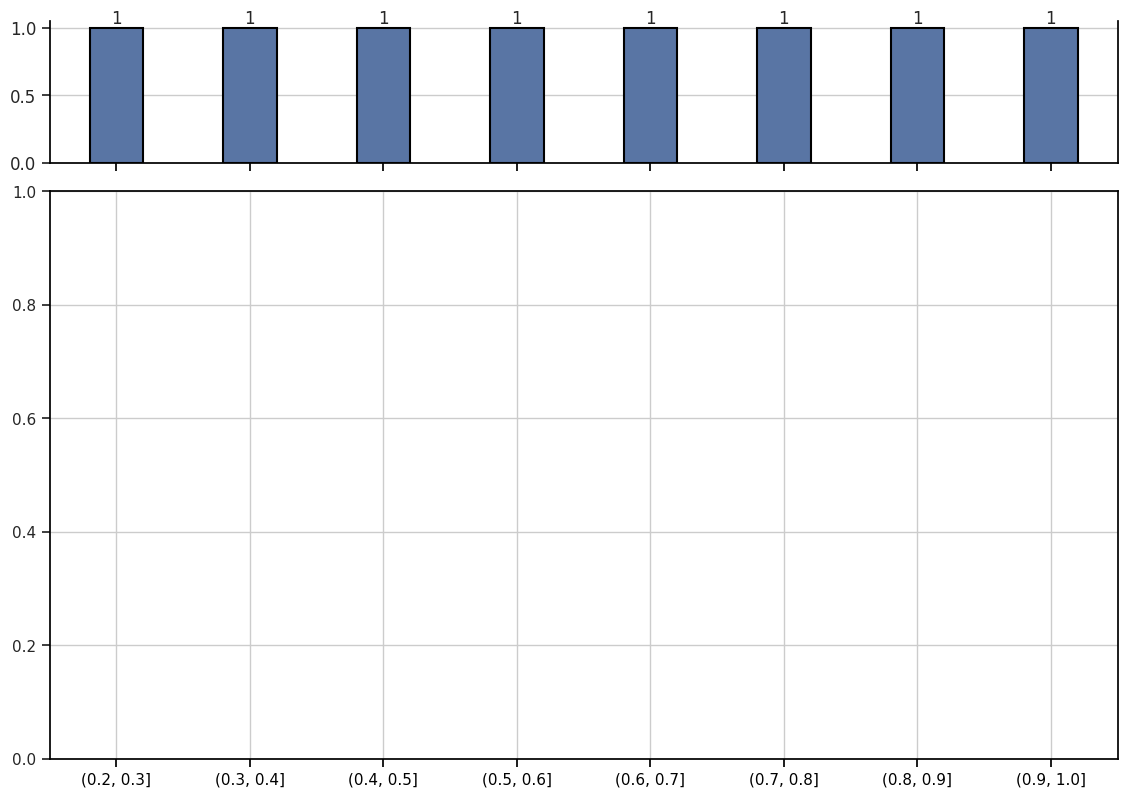

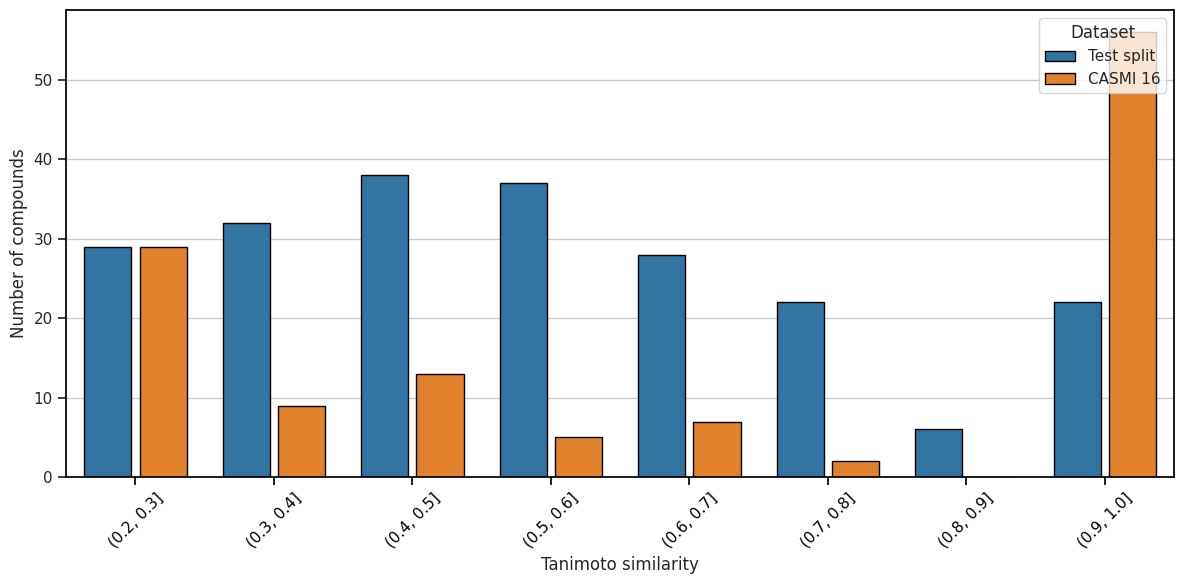

In [61]:
if calc_tanimoto:

    fig, axs = plt.subplots(1,1, figsize=(12, 6))


    # Bin the data based on 'tanimoto3'
    binned_data = pd.cut(C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)]["tanimoto3"], 
                        bins=[x/10.0 for x in range(2, 11, 1)])

    # Group by both binned_data and 'Dataset', then count unique 'group_id'
    grouped_data = C[(C["Precursor_type"] == "[M+H]+") & C["Dataset"].isin(datasets)].groupby([binned_data, "Dataset"])["group_id"].nunique().reset_index(name="unique_group_ids")

    sns.barplot(x="tanimoto3", y="unique_group_ids", hue="Dataset", data=grouped_data, palette="tab10", hue_order=datasets, edgecolor="black", gap=0.15)

    plt.xlabel("Tanimoto similarity")
    plt.ylabel("Number of compounds")
    plt.xticks(rotation=45)
    plt.legend(title="Dataset",loc='upper right')
    plt.tight_layout()

    # fig.savefig(f"{home}/images/paper/tanimoto_distribution.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_distribution.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
    # fig.savefig(f"{home}/images/paper/tanimoto_distribution.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)
    plt.show()


In [68]:
if calc_tanimoto:
    medians = C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")].groupby(pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2, 11, 1))]))['spectral_sqrt_cosine'].median()
    print(f"Fiora: {medians.min() / medians.max()}")
    medians = C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")].groupby(pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2, 11, 1))]))['ice_sqrt_cosine'].median()
    print(f"ICEBERG: {medians.min() / medians.max()}")


Fiora: 0.8389002378493793
ICEBERG: 0.7421145603660584


/tmp/ipykernel_1758053/2650629896.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")].groupby(pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[x/10.0 for x in list(range(2, 11, 1))]))['spectral_sqrt_cosine'].median()
/tmp/ipykernel_1758053/2650629896.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")].groupby(pd.cut(C[(C["Precursor_type"] == "[M+H]+") & (C["Dataset"] == "Test split")]['tanimoto3'], bins=[

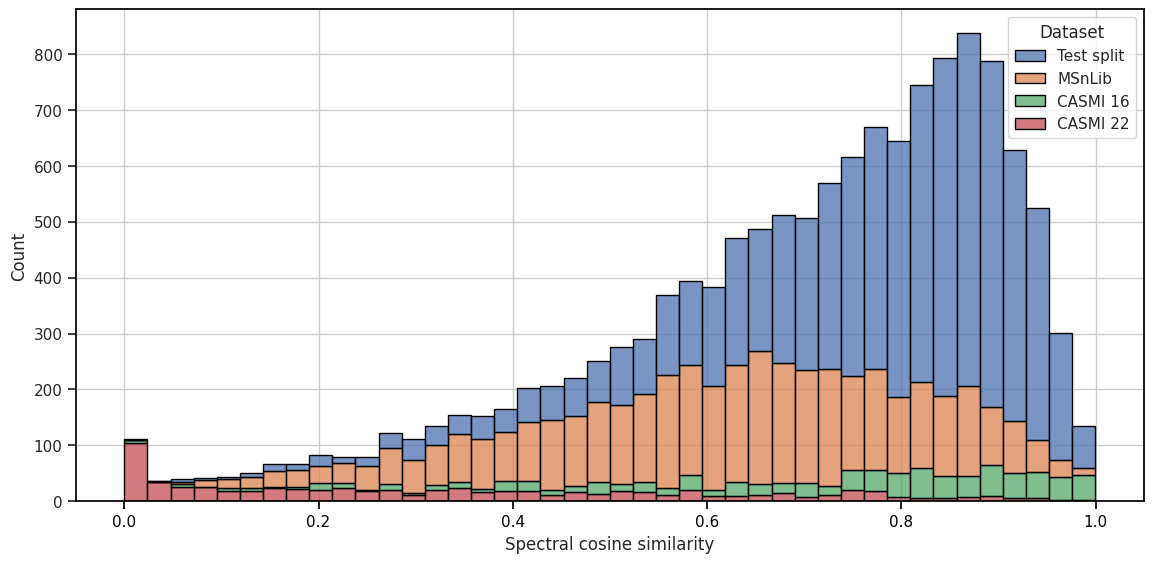

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08, hspace=0.1)

C = pd.concat([df_test, df_msnlib_test, df_cas, df_cas22], ignore_index=True)

sns.histplot(C, ax=ax, x="spectral_sqrt_cosine", hue="Dataset", linewidth=1, multiple="stack", edgecolor="black")
ax.set_xlabel("Spectral cosine similarity")

# fig.savefig(f"{home}/images/paper/histplot_cosine.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/histplot_cosine.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/histplot_cosine.pdf", format="pdf", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()